# Animal classification

### Introduction

In this notebook we will build a convolutional neural network (CNN) to classify images of animals that are part of the Big Five. This group traditionally consists of the buffalo, elephant, leopard, lion, and rhinoceros. We will collect the data ourselves through web scraping. Since the different classes will be balanced, we can use accuracy as a metric to assess model performance.

### Imports and settings

In [1]:
# Standard Python libraries:
import datetime
import glob
import operator
import os
import pickle
import random
import shutil
import sys
from typing import List, Tuple
import warnings

# Data processing and modeling:
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Data visualization:
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

# Other third-party libraries:
from nptyping import NDArray
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

# Code repository imports:
from googlescraper import GoogleScraper

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)
sns.set_theme()

### Data acquisition

In this project we collect our own data through web scraping. Regarding the web scraper (see the module named 'googlescraper'), credits go to Nikola Zivkovic from [Rubik's Code](https://rubikscode.net/2021/06/21/scraping-images-with-python). Note that all images are automatically converted to type RGB and saved as jpg files.

In [2]:
# Set up the appropriate webdriver and define the image scraper:
# headless_options = Options()
# headless_options.add_argument("--headless")  # Disables opening of browser window.
# driver = webdriver.Chrome(ChromeDriverManager().install(), options=headless_options)
# driver.get("https://google.com")
# scraper = GoogleScraper(driver)

# Acquire the maximum number of images possible with Google. 
# Both the animals' English and Latin names are used in the search queries.
animals = {
    "buffalo": ["african buffalo", "syncerus caffer"],
    "elephant": ["african elephant", "loxodonta"], 
    "leopard": ["african leopard", "panthera pardus pardus"], 
    "lion": ["lion", "panthera leo"], 
    "rhinoceros": ["black rhinoceros", "diceros bicornis"],
}
data_dir = "data"
# for animal, queries in animals.items():
#     folder = os.path.join(data_dir, animal)
#     for query in queries:
#         scraper.scrape_images(query, folder)

We have collected the following numbers of images for each animal class:

In [3]:
print("Number of images per class:\n")
for animal in animals:
    folder = os.path.join(data_dir, animal)
    number_images = len(os.listdir(folder))
    print(f"{animal}: {number_images} images")

Number of images per class:

buffalo: 1388 images
elephant: 1446 images
leopard: 1398 images
lion: 1423 images
rhinoceros: 1405 images


### Data exploration

To get a feel for the data we are working with, let us inspect a few random images. For convenience, let us define the following function:

In [4]:
def select_random_img(dir_path: str) -> str:
    """Selects a random image from the provided folder.
    
    Args:
        dir_path: Path to the folder from which a random image 
            needs to be selected.
    
    Returns:
        The path to a random image.
    """
    
    image_paths = [os.path.join(dir_path, image_name) for image_name in os.listdir(dir_path)]
    random.seed(0)
    rand_int = random.randrange(len(image_paths))
    example_path = image_paths[rand_int]
    
    return example_path

Three random images from our dataset:

Size:	 (312, 162)


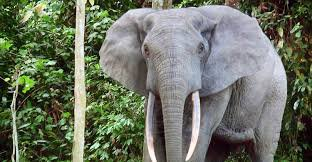

In [5]:
example_dir = os.path.join(data_dir, "elephant")
example_path = select_random_img(example_dir)
example_img = load_img(example_path)
print("Size:\t", example_img.size)
display.Image(example_path)

Size:	 (262, 192)


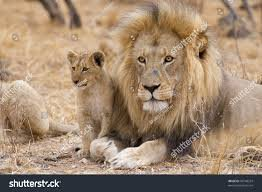

In [6]:
example_dir = os.path.join(data_dir, "lion")
example_path = select_random_img(example_dir)
example_img = load_img(example_path)
print("Size:\t", example_img.size)
display.Image(example_path)

Size:	 (1440, 911)


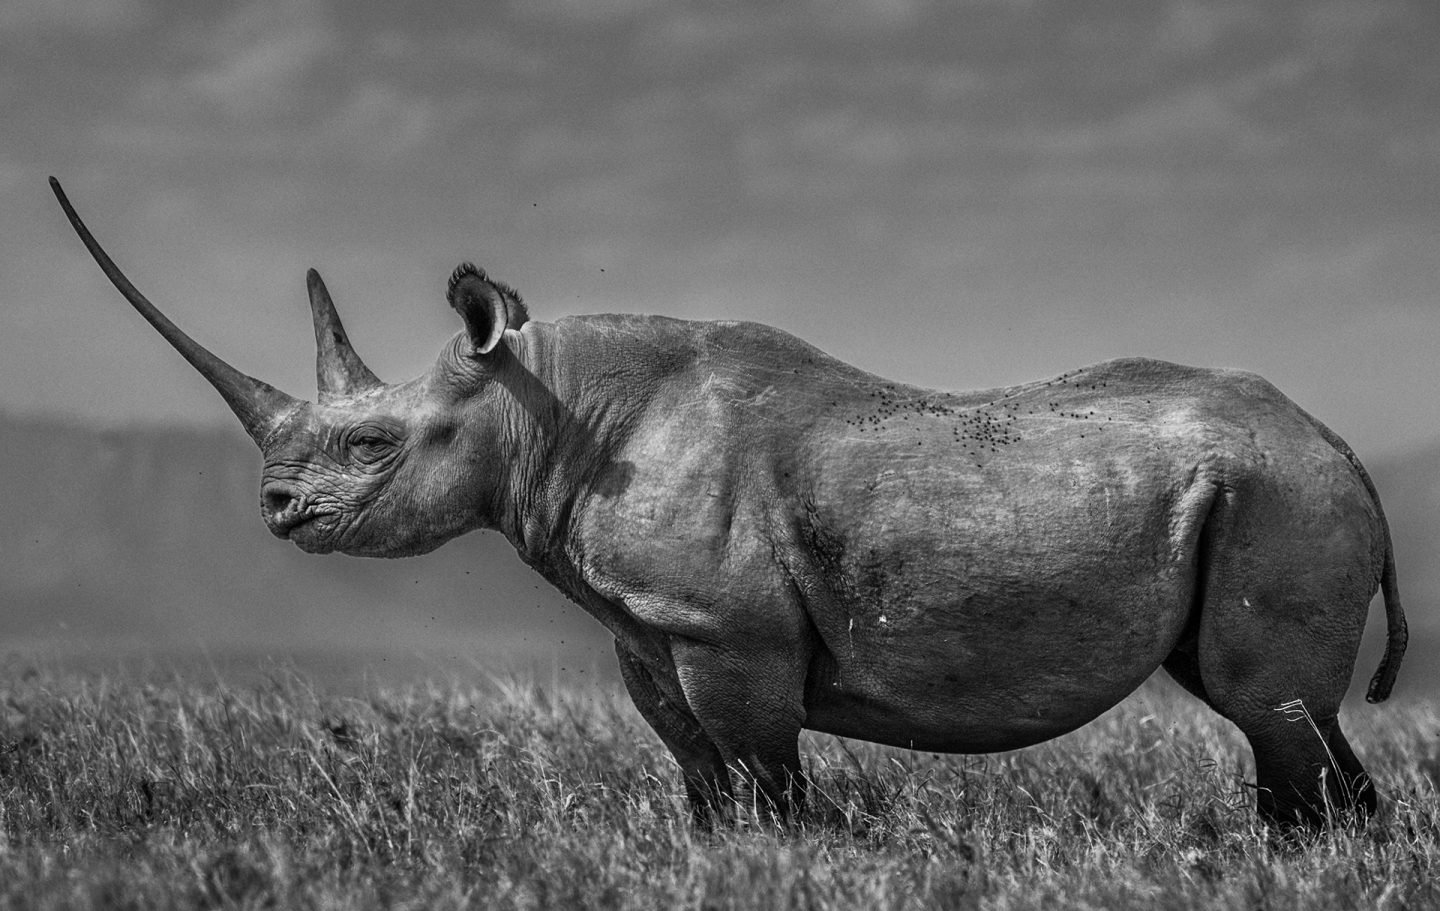

In [7]:
example_dir = os.path.join(data_dir, "rhinoceros")
example_path = select_random_img(example_dir)
example_img = load_img(example_path)
print("Size:\t", example_img.size)
display.Image(example_path)

Note that the images have (very) different dimensions. As our CNN will require a fixed input size, all images need to have the same resolution. This means that we might need to rescale or drop certain images. In the following we will inspect all resolutions that occur in our dataset. To this end, we will define a function that can obtain the full paths of all images in a given folder:

In [8]:
def get_images(dir_path: str) -> List[str]:
    """Obtains paths to all jpg files in the given directory.

    Args:
        dir_path: The path to the directory.

    Returns:
        List of full paths to all jpg images that are contained
        in the input directory, including subdirectories.
    """

    list_of_items = os.listdir(dir_path)
    full_paths = []
    for item in list_of_items:
        full_path = os.path.join(dir_path, item).strip()
        if os.path.isdir(full_path):
            full_paths = full_paths + get_images(full_path)
        else:
            if full_path.endswith(".jpg"):
                full_paths.append(full_path)

    return full_paths

An inspection of the full set of images gives the following results:

In [9]:
resolutions = {}
img_paths = get_images(data_dir)
for img_path in img_paths:
    img = load_img(img_path)      
    size = img.size            
    resolution = size[0] * size[1]
    if resolution not in resolutions:
        resolutions[resolution] = 1
    else:
        resolutions[resolution] += 1
resolutions = dict(sorted(resolutions.items(), reverse=True))
size_dataset = len(img_paths)
print(f"There is a total number of {size_dataset} images in the dataset.\n")
print(f"Number of pixels and their count:\n\n{resolutions}")

There is a total number of 7060 images in the dataset.

Number of pixels and their count:

{14870982: 1, 14077952: 1, 13794000: 1, 12493494: 2, 12212224: 4, 12192768: 1, 12052992: 1, 12000000: 1, 11376144: 1, 11297591: 1, 11089920: 1, 10965696: 1, 10960896: 1, 10912062: 1, 10628820: 1, 10480610: 1, 10202112: 1, 10068672: 1, 10036224: 2, 10024000: 1, 9980928: 3, 9830400: 1, 9826326: 1, 9784320: 1, 9777880: 1, 9765504: 1, 9700000: 1, 9690098: 1, 9639261: 1, 9437184: 3, 9407448: 1, 9270294: 1, 8847360: 1, 8800000: 2, 8724485: 1, 8670000: 1, 8329011: 1, 8294400: 1, 8185344: 1, 8165500: 1, 7990272: 1, 7962624: 2, 7750656: 1, 7601856: 1, 7492608: 1, 7307184: 1, 7272782: 1, 7077888: 1, 6899712: 1, 6826500: 1, 6808403: 1, 6756480: 1, 6634958: 1, 6488064: 1, 6476800: 1, 6465701: 1, 6460560: 1, 6291456: 4, 6282240: 1, 6276096: 1, 6252500: 1, 6220800: 1, 6200992: 1, 6200650: 1, 6096000: 1, 6085800: 1, 6072000: 1, 6016000: 2, 6003000: 1, 6000000: 3, 5988000: 1, 5769000: 2, 5762400: 3, 5712500: 1, 

The sizes of the images vary considerably. More specifically, the number of pixels per image ranges from ~10,000 to ~10,000,000; a difference of three orders of magnitude! As we prefer downsampling over upsampling, we need to find a (low) resolution that can serve as the fixed input size for our network such that we still have a sufficient number of images. We will work with a square resolution so that horizontal and vertical images are treated on an equal footing. Let us visualize the number of images with a resolution above a given threshold:

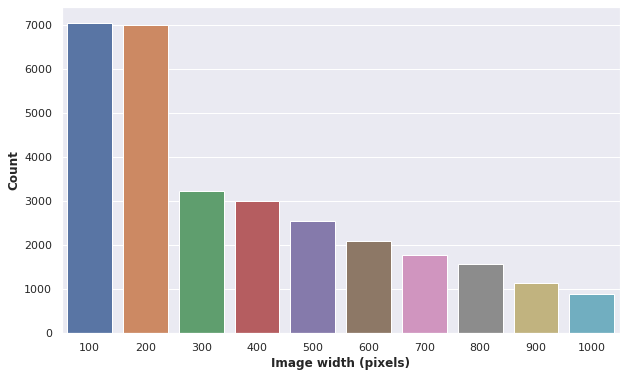

In [10]:
widths = [100 * i for i in range(1, 11)]
sizes = [width ** 2 for width in widths]
total_counts = []
for size in sizes:
    total_count = 0
    for resolution, count in resolutions.items():
        total_count += count if resolution >= size else 0
    total_counts.append(total_count)

plt.figure(figsize=(10,6))
sns.barplot(x=widths, y=total_counts)
plt.xlabel("Image width (pixels)", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.show()

Note the big drop in image count from 200 to 300. If we were to pick 200 as the desired image width, we would retain almost all images. However, as 200 is rather low, we prefer a higher resolution. From the chart we infer that the difference between 300 and 400 is neglible and that there is a (small) drop again between 400 and 500. Hence, it seems that 400 would be a reasonable image width to pick where we retain ~3,000 images in total.

### Preprocessing

As customary, we want to create train, dev, and test sets. To this end, we will distribute the original data over these sets in a random fashion, aiming for an 80-10-10 split. We will discard all images that have a resolution less than 400 x 400 = 160,000 pixels. To avoid removing or duplicating data, we will perform this split only virtually; we will simply create separate sets of image paths based on our data directory.

In [11]:
train_set = []
dev_set = []
test_set = []
img_paths = get_images(data_dir)
random.seed(0)
random.shuffle(img_paths)
for img_path in img_paths:
    img = load_img(img_path)      
    size = img.size            
    resolution = size[0] * size[1]
    if resolution >= 400 ** 2:
        rand_int = random.randrange(10)
        if rand_int <= 7:
            train_set.append(img_path)
        elif rand_int == 8:
            dev_set.append(img_path)
        else:
            test_set.append(img_path)

print("Size of training set:\t\t", len(train_set))
print("Size of development set:\t", len(dev_set))
print("Size of test set:\t\t", len(test_set))

Size of training set:		 2403
Size of development set:	 276
Size of test set:		 319


Our CNN expects integer labels rather than class names. To this end, the class names need to be converted to labels:

In [12]:
classes = [os.path.basename(folder) for folder in os.listdir(data_dir) if not folder.startswith(".")]
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

Before we can train a model, we need to put our data into the right form. All images will be downsampled to our target resolution of 400 x 400 pixels. To compensate for the original non-squareness, we can pad the images with zeros (i.e. add black pixels) to preserve the aspect ratio. For convenience, let us first define a function that resizes and pads images and outputs a feature tensor and one-hot encoded labels:

In [13]:
def img_resize_pad(
    img_paths: List[str], 
    target_size: Tuple[int, int],
    label_encoder: LabelEncoder,
) -> Tuple[NDArray[float], NDArray[float]]:
    """Resizes images in given dataset to desired size.
    
    Zero padding is used to respect the original aspect ratio.

    Args:
        img_paths: Collection of (full) image paths.
        target_size: The desired height and width of the images.
        label_encoder: A LabelEncoder object that has been fitted to the classes.

    Returns:
        The 4D feature tensor as well as the one-hot-encoded labels.
    """
    
    # Resize images to target dimensions with padding:
    target_height, target_width = target_size
    img_list = []
    label_list = []
    for img_path in img_paths:
        img = load_img(img_path)
        img_arr = img_to_array(img)
        img_pad_arr = tf.image.resize_with_pad(
            img_arr,
            target_height,
            target_width,
        )
        img_pad_arr /= 255.0  # Map pixel values to the inverval [0,1].
        img_list.append(img_pad_arr)
        label = os.path.basename(os.path.dirname(img_path))
        label_list.append(label)

    # Create feature and label tensors:    
    features = np.stack(img_list, axis=0)
    labels = label_encoder.transform(label_list)
    labels = to_categorical(labels)
    
    return features, labels

Now we are ready to create the input and output tensors for our CNN. Let us start with the training set:

In [14]:
target_size = (400, 400)
train_features, train_labels = img_resize_pad(train_set, target_size, label_encoder)
print("Dimensions of tensor for input features:\t", train_features.shape)
print("Dimensions of tensor for output labels:\t\t", train_labels.shape)

###################
# train_features = train_features[0:16, :, :, :]
# train_labels = train_labels[0:16, :]

Dimensions of tensor for input features:	 (2403, 400, 400, 3)
Dimensions of tensor for output labels:		 (2403, 5)


Analogously, we can create the dev and test tensors:

In [15]:
dev_features, dev_labels = img_resize_pad(dev_set, target_size, label_encoder)
test_features, test_labels = img_resize_pad(test_set, target_size, label_encoder)

###################
# dev_features = dev_features[0:16, :, :, :]
# dev_labels = dev_labels[0:16, :]
# test_features = test_features[0:16, :, :, :]
# test_labels = test_labels[0:16, :]

It is good practice to check whether the resized and padded images are indeed what we expect them to be. So let us look at a few examples from the training set:

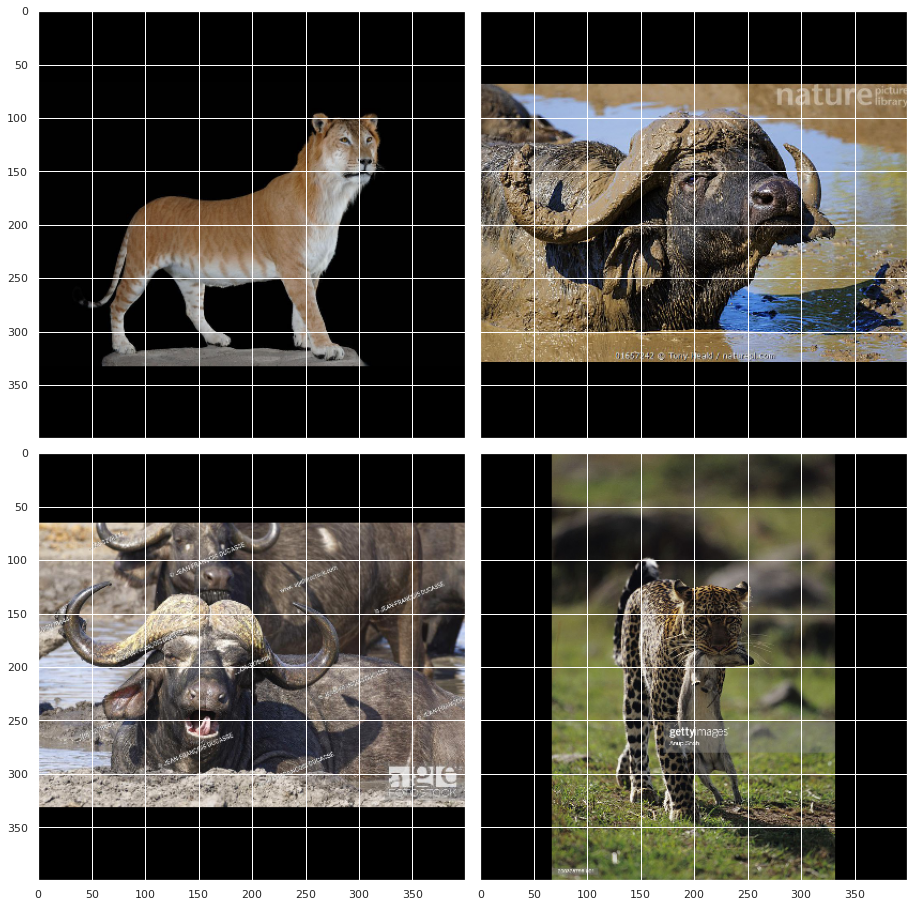

In [16]:
# Randomly select 4 images:
img_arrays = []
random.seed(10)
rand_ints = random.sample(range(train_features.shape[0]), 4)
for i in rand_ints:
    example_array = train_features[i, :, :, :]
    img_arrays.append(example_array)

# Create image grid:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.2)
for ax, im in zip(grid, img_arrays):
    ax.imshow(im)
plt.show()

### Model building

In this section we build and train a CNN using Keras. For the model architecture we try a combination of convolutional and dense layers, supplemented with pooling layers. We wrap the architecture in a function so that we can easily try different hyperparameters.

In [17]:
def create_model(
    input_shape: Tuple[int], 
    num_classes: int, 
    dropout_rate: float = 0.0, 
    l2_lambda: float = 0.0,
) -> Sequential:
    """Defines model architecture and compiles model.
    
    The loss function, the optimization algorithm, and the evaluation metric
    are set as well. By default, no form of regularization is applied.
    
    Args:
        input_shape: Dimensions of input tensor.
        num_classes: Number of different output classes.
        dropout_rate: Probability for switching off a neuron in the given layer.
        l2_lambda: Determines the amount of L2 weight regularization.
    
    Return:
        A Keras Sequential object representing a CNN.
    """

    model = Sequential(name="CNN_for_animal_classification")
    model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
    model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
    model.add(Conv2D(16, kernel_size=(5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2=l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate, seed=0))
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(l2=l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate, seed=0))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="adam", 
        loss="categorical_crossentropy", 
        metrics=["accuracy"],
    )
    
    return model

We will build four different models: one without any form of regularization (*no_reg*), one with dropout regularization (*drop*), one with L2 regularization (*l2*), and one with both dropout and L2 regularization (*drop_l2*). These models have the same architecture; they only differ by choices of regularization parameters.

In [18]:
input_shape = (*target_size, 3)
num_classes = train_labels.shape[1]

models = {
    "no_reg": create_model(input_shape, num_classes), 
#     "drop": create_model(input_shape, num_classes, dropout_rate = 0.5),
#     "l2": create_model(input_shape, num_classes, l2_lambda = 0.01), 
#     "drop_l2": create_model(input_shape, num_classes, dropout_rate = 0.5, l2_lambda = 0.01),
}
models["no_reg"].summary()

Model: "CNN_for_animal_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 400, 400, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 400, 400, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 400, 400, 64)      102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 400, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      51232     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1

The train, dev, and test sets can be defined using the *ImageDataGenerator* class. Naturally, data augmentation is only applied to the train set. (An advantage of using the *flow* rather than the *flow_from_directory* method is that with the former we have more control over the preprocessing of the images, particularly the rescaling.)

In [19]:
batch_size = 8

# Specify training set, including data augmentation:
train_datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="constant",
    cval=0,  # Pad with black pixels.
    horizontal_flip=True,
)
train_generator = train_datagen.flow(
    train_features,
    y=train_labels,
    batch_size=batch_size,
)

# Specify development set:
dev_datagen = ImageDataGenerator()
dev_generator = dev_datagen.flow(
    dev_features,
    y=dev_labels,
    batch_size=batch_size,
)

# Specify test set:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    test_features,
    y=test_labels,
    batch_size=batch_size,
    shuffle=False,
)

The weights that pertain to the epoch with the highest accuracy on the dev set will be automatically saved to an h5 file. To this end, we define the following callback:

In [20]:
weights_callbacks = {}
# tb_callbacks = {}
for model_name in models:
    # Define the weights callback:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    weights_path = "weights_" + model_name + "_" + current_time + ".h5"
    weights_callback = ModelCheckpoint(
        filepath=weights_path, 
        monitor="val_accuracy", 
        mode="max",  # Weights are selected based on max accuracy on the dev set.
        save_best_only=True,
    )
    weights_callbacks.update({model_name: weights_callback})
    
#     # Define the TensorBoard callback:
#     if os.path.isdir(f"logs_{model_name}"):
#         shutil.rmtree(f"logs_{model_name}")
#     log_dir = os.path.join(f"logs_{model_name}", current_time)
#     tb_callback = TensorBoard(log_dir, histogram_freq=1)
#     tb_callbacks.update({model_name: tb_callback})

Finally, we can train our CNN for the four different hyperparameter settings. The accuracy and loss functions are saved to a pickle file (for possible future use).

In [21]:
# # Train models:
# epochs = 50
# histories = {}
# for model_name, model in models.items():
#     history = model.fit(
#         x=train_generator,
#         epochs=epochs,
#         steps_per_epoch=len(train_generator),
#         validation_data=dev_generator,
#         validation_steps=len(dev_generator),
#         callbacks=[weights_callbacks[model_name]],
# #         callbacks=[tb_callbacks[model_name], weights_callbacks[model_name]],
#         verbose=0,
#     )
#     histories.update({model_name: history.history})

# # Pickle training history:    
histories_path = "histories.pkl"
# with open(histories_path, "wb") as f:
#     pickle.dump(histories, f)

Based on the accuracy of the dev set we can select the best model. We can choose from the four models with different regularization settings, as well as from the various training epochs. This is achieved by searching for the maximum value of *val_accuracy* across all models and epochs:

In [22]:
# Unpickle training history:
with open(histories_path, "rb") as f:
    histories = pickle.load(f)

# Find best model:
best_score = -1.0
best_choice = None
for model_name, history in histories.items():
    dev_scores = history["val_accuracy"]
    max_value = max(dev_scores)
    if max_value > best_score:
        best_score = max_value
        best_choice = model_name
print(f"Model with the highest accuracy on the dev set: {best_choice}.")

# Select best model:
best_weights_path = glob.glob(f"weights_{best_choice}_*.h5")[0]
best_model = load_model(best_weights_path)

Model with the highest accuracy on the dev set: no_reg.


Let us visualize the accuracy and loss for the train and dev sets for the most optimal choice of hyperparameters:

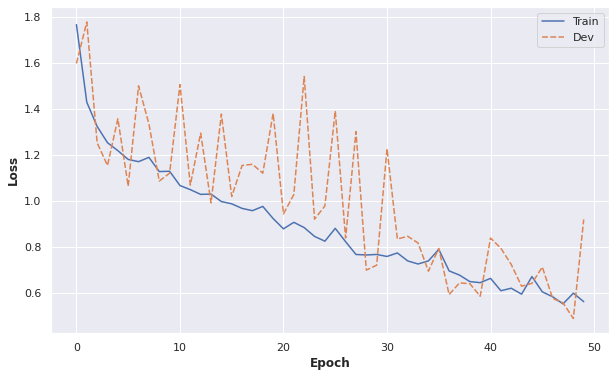

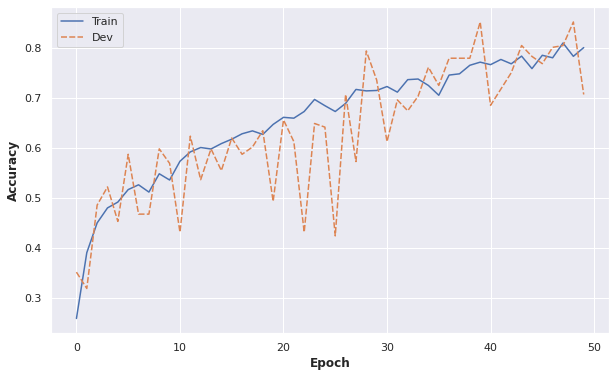

In [23]:
def train_dev_plot(metric: str, train_data: List[float], dev_data: List[float]):
    """Draws plot for train and dev sets for given metric.
    
    Args:
        metric: Name of metric.
        train_data: Values of metric for train data per epoch.
        dev_data: Values of metric for dev data per epoch.
    """
    
    plt.figure(figsize=(10,6))
    plot_data = pd.DataFrame({"Train": train_data, "Dev": dev_data})
    sns.lineplot(data=plot_data)
    plt.xlabel("Epoch", fontweight="bold")
    plt.ylabel(metric, fontweight="bold")
    plt.show()

best_hist = histories[best_choice]
train_dev_plot("Loss", best_hist["loss"], best_hist["val_loss"])  
train_dev_plot("Accuracy", best_hist["accuracy"], best_hist["val_accuracy"])
 
# Visualize loss and accuracy with TensorBoard for the train and dev sets:
# %load_ext tensorboard
# logs = "logs_" + best_choice
# %tensorboard --logdir logs

### Conclusions

In this final section we will test and investigate our (best) model, draw conclusions, and provide some directions for further improvements.

#### Test results

Now that we have selected our best model, we can evaluate it on the test set and calculate its accuracy:

In [24]:
test_results = best_model.evaluate(x=test_generator, verbose=0)
test_accuracy = test_results[1]*100
print(f"\nModel accuracy: {round(test_accuracy, 2)}%.")


Model accuracy: 79.94%.


To get a better feeling for our model, let us predict the type of animal for a few random images:

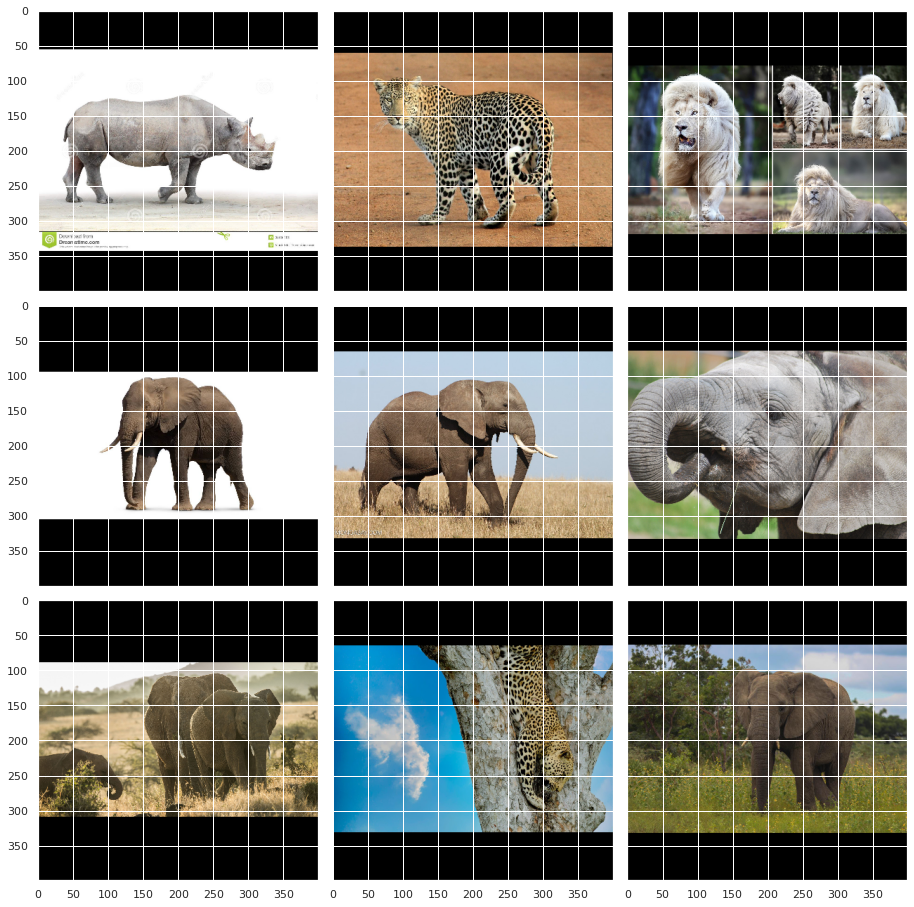

[['rhinoceros' 'leopard' 'lion']
 ['elephant' 'elephant' 'rhinoceros']
 ['elephant' 'leopard' 'elephant']]


In [25]:
# Randomly select 9 images:
test_arrays = []
random.seed(0)
rand_ints = random.sample(range(test_features.shape[0]), 9)
for i in rand_ints:
    test_array = test_features[i, :, :, :]
    test_arrays.append(test_array)

# Create image grid:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.2)
for ax, im in zip(grid, test_arrays):
    ax.imshow(im)
plt.show()

# Predict class on images:
test_features_subset = np.stack(test_arrays, axis=0)
prediction_labels = best_model.predict_classes(x=test_features_subset)
prediction_classes = label_encoder.inverse_transform(prediction_labels)
prediction_classes = np.array(prediction_classes).reshape(3, 3)
print(prediction_classes)

In this example, 8 out of 9 predictions are correct (the 6th image represents an elephant and not a rhinoceros). Finally, it is often helpful to study the confusion matrix to identify weak points of the model. (Note that with *argmax*, the inverse of *to_categorical*, we can transform the one-hot-encoded labels to integers.)

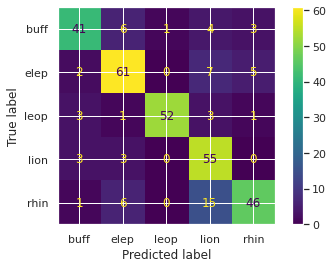

In [26]:
# Obtain true labels from the test generator:
label_true_ohe = test_generator.y
label_true = np.argmax(label_true_ohe, axis=1)

# Use best model to predict on the test set:
label_pred_ohe = best_model.predict(test_generator)
label_pred = np.argmax(label_pred_ohe, axis=1)

# Compute confusion matrix:
labels = np.array(range(num_classes))
classes = label_encoder.inverse_transform(labels)
class_abbr = [class_name[:4] for class_name in list(classes)]
conf_matrix = confusion_matrix(label_true, label_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_abbr).plot()

To understand how well our model performs for the different classes, we can calculate the proportions of misclassifications for each class:

In [27]:
for i in range(num_classes):
    miscl_sum = 0
    total_sum = np.sum(conf_matrix, axis=0)[i]
    correct = conf_matrix[i, i]
    miscl_prop = round(1 - correct / total_sum, 2)
    print(f"Proportion misclassified {classes[i]}: {miscl_prop}.")

Proportion misclassified buffalo: 0.18.
Proportion misclassified elephant: 0.21.
Proportion misclassified leopard: 0.02.
Proportion misclassified lion: 0.35.
Proportion misclassified rhinoceros: 0.16.


#### Summary and discussion

In this notebook we built a CNN to classify Big Five animals. We gathered the data ourselves from Google Images. To make sure that images with horizontal and vertical orientations were treated on an equal footing, we resized all images to a fixed, square size of 400 x 400 pixels. To respect the original aspect ratios, we performed a zero padding. Furthermore, to avoid poor-quality imagery in our analysis, we dropped all images with a resolution lower than the target one. For the labels we performed one-hot encoding.

We built a neural network from a combination of convolutional and dense layers, supplemented with pooling layers. As it is impossible to know in advance whether the network requires regularization, we decided to test four cases: one without any form of regularization (*no_reg*), one with dropout regularization (*drop*), one with L2 regularization (*l2*), and one with both dropout and L2 regularization (*drop_l2*). To increase the number of input images and to reduce variance, we applied data augmentation to the train set.

We trained the models on a compute optimized EC2 instance on AWS to speed up the process. (The largest possible batch size for the machine used was 8.) To asses model performance, we studied the accuracy on the dev set. Accuracy is a good metric as our classes are balanced. As it turns out, the model that performed best was the *no_reg* model. This means that our model does not suffer from high variance and generalizes relatively well. On the test set, this model achieved an accuracy of 80%. Compared to Bayes error (<1%), our accuracy is nothing spectacular. The confusion matrix is highly diagonal, which is a good sign. However, lions are misclassified 35% of the time which seems fairly high. A lion is often incorrectly identified as a rhinoceros.

With more time and compute resources, our model can be improved in various ways. First of all, by looking at the loss function, we infer that the model was actually still improving over the last epochs. Both the train and dev losses were still showing a downward trend. This means that we stopped training too early. A slightly larger learning rate might speed up the training process. A deeper or more complex network might reduce bias further. In that case, regularization might be beneficial. Another thing that often proves useful is cleaning up the data; web scraping introduced a number of 'strange' images in our dataset, such as drawings, logos, and even images of completely different things. Further analysis might reveal that our 'lion' problem is related to poor data.